In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
tqdm.pandas()
import sys
sys.path.insert(1, "../../measures/intricacy/")
from calculate_intricacy import *
sys.path.insert(1, "../../measures/local spatial complexity/")
from calculate_local_spatial_complexity import *
import warnings
warnings.filterwarnings("ignore")
np.random.seed(34)

In [2]:
def calculate_measures(grid):
    LSC = calculate_local_spatial_complexity(grid, grid_size)
    intricacy = calculate_intricacy(grid, grid_size)
    return LSC, intricacy

def simulate_underlying_random(grid):
    measures = np.zeros((num_sims, 2))
    gray_indices = grid == 2
    for i in range(num_sims):
        grid_ = grid.copy()
        grid_[gray_indices] = np.random.choice([0, 1], size=np.sum(gray_indices))
        measures[i, :] = calculate_measures(grid_)
    meanLSC, meanInt = np.mean(measures, axis=0)
    return meanLSC, meanInt

def simulate_underlying_permutation(grid, pattern_id):
    measures = np.zeros((num_patterns - 1, 2))
    gray_indices = grid == 2
    ind = 0
    for i in range(num_patterns):
        if i + 1 == pattern_id:
            continue
        grid_ = grid.copy()
        replacement_pattern = np.array(list(map(int, pattern_stats[pattern_stats["pattern_id"] == i + 1]["stimuli"].item()))).reshape(grid_size, grid_size)
        grid_[gray_indices] = replacement_pattern[gray_indices]
        measures[ind, :] = calculate_measures(grid_)
        ind += 1
    meanLSC, meanInt = np.mean(measures, axis=0)
    return meanLSC, meanInt

def simulate_visible_random(grid, LSC_nondetrended, Int_nondetrended):
    measures = np.zeros((num_sims, 2))
    non_gray_indices = grid != 2
    for i in range(num_sims):
        grid_ = grid.copy()
        grid_[non_gray_indices] = np.random.choice(
            [0, 1], size=np.sum(non_gray_indices)
        )
        measures[i, :] = calculate_measures(grid_)
    meanLSC, meanInt = np.mean(measures, axis=0)
    return LSC_nondetrended - meanLSC, Int_nondetrended - meanInt

def simulate_visible_permutation(grid, LSC_nondetrended, Int_nondetrended, pattern_id):
    measures = np.zeros((num_patterns - 1, 2))
    non_gray_indices = grid != 2
    ind = 0
    for i in range(num_patterns):
        if i + 1 == pattern_id:
            continue
        grid_ = grid.copy()
        replacement_pattern = np.array(list(map(int, pattern_stats[pattern_stats["pattern_id"] == i + 1]["stimuli"].item()))).reshape(grid_size, grid_size)
        grid_[non_gray_indices] = replacement_pattern[non_gray_indices]
        measures[ind, :] = calculate_measures(grid_)
        ind += 1
    meanLSC, meanInt = np.mean(measures, axis=0)
    return LSC_nondetrended - meanLSC, Int_nondetrended - meanInt

In [3]:
pattern_stats = pd.read_csv("../../csvs/grid-search/pattern_stats.csv")

In [4]:
grid_size = 27
num_sims = 10
num_patterns = 98

grid_data = pd.read_csv("../../csvs/grid-search/grid_data_reevaluatedforreproduction.csv")
click_data = pd.read_csv("../../csvs/grid-search/click_data_reevaluatedforreproduction.csv")

In [ ]:
grid_data[["uLSCr", "uIntr"]] = grid_data.progress_apply(
    lambda row: pd.Series(
        simulate_underlying_random(
            np.array(list(map(int, row["final_grid"]))).reshape(
                grid_size, grid_size
            )
        )
    ),
    axis=1,
)

In [ ]:
grid_data[["uLSCp", "uIntp"]] = grid_data.progress_apply(
    lambda row: pd.Series(
        simulate_underlying_permutation(
            np.array(list(map(int, row["final_grid"]))).reshape(
                grid_size, grid_size
            ), row["pattern_id"]
        )
    ),
    axis=1,
)

In [ ]:
grid_data[["fLSCr", "fIntr"]] = grid_data.progress_apply(
    lambda row: pd.Series(
        simulate_visible_random(
            np.array(list(map(int, row["final_grid"]))).reshape(
                grid_size, grid_size
            ),
            row["fLSC_nondetrended"],
            row["fInt_nondetrended"],
        )
    ),
    axis=1,
)

In [ ]:
grid_data[["fLSCp", "fIntp"]] = grid_data.progress_apply(
    lambda row: pd.Series(
        simulate_visible_permutation(
            np.array(list(map(int, row["final_grid"]))).reshape(grid_size, grid_size),
            row["fLSC_nondetrended"],
            row["fInt_nondetrended"],
            row["pattern_id"]
        )
    ),
    axis=1,
)

In [ ]:
grid_data["uLSCdiffr"] = grid_data["uLSC"] - grid_data["uLSCr"]
grid_data["uIntdiffr"] = grid_data["uInt"] - grid_data["uIntr"]

grid_data["uLSCdiffp"] = grid_data["uLSC"] - grid_data["uLSCp"]
grid_data["uIntdiffp"] = grid_data["uInt"] - grid_data["uIntp"]

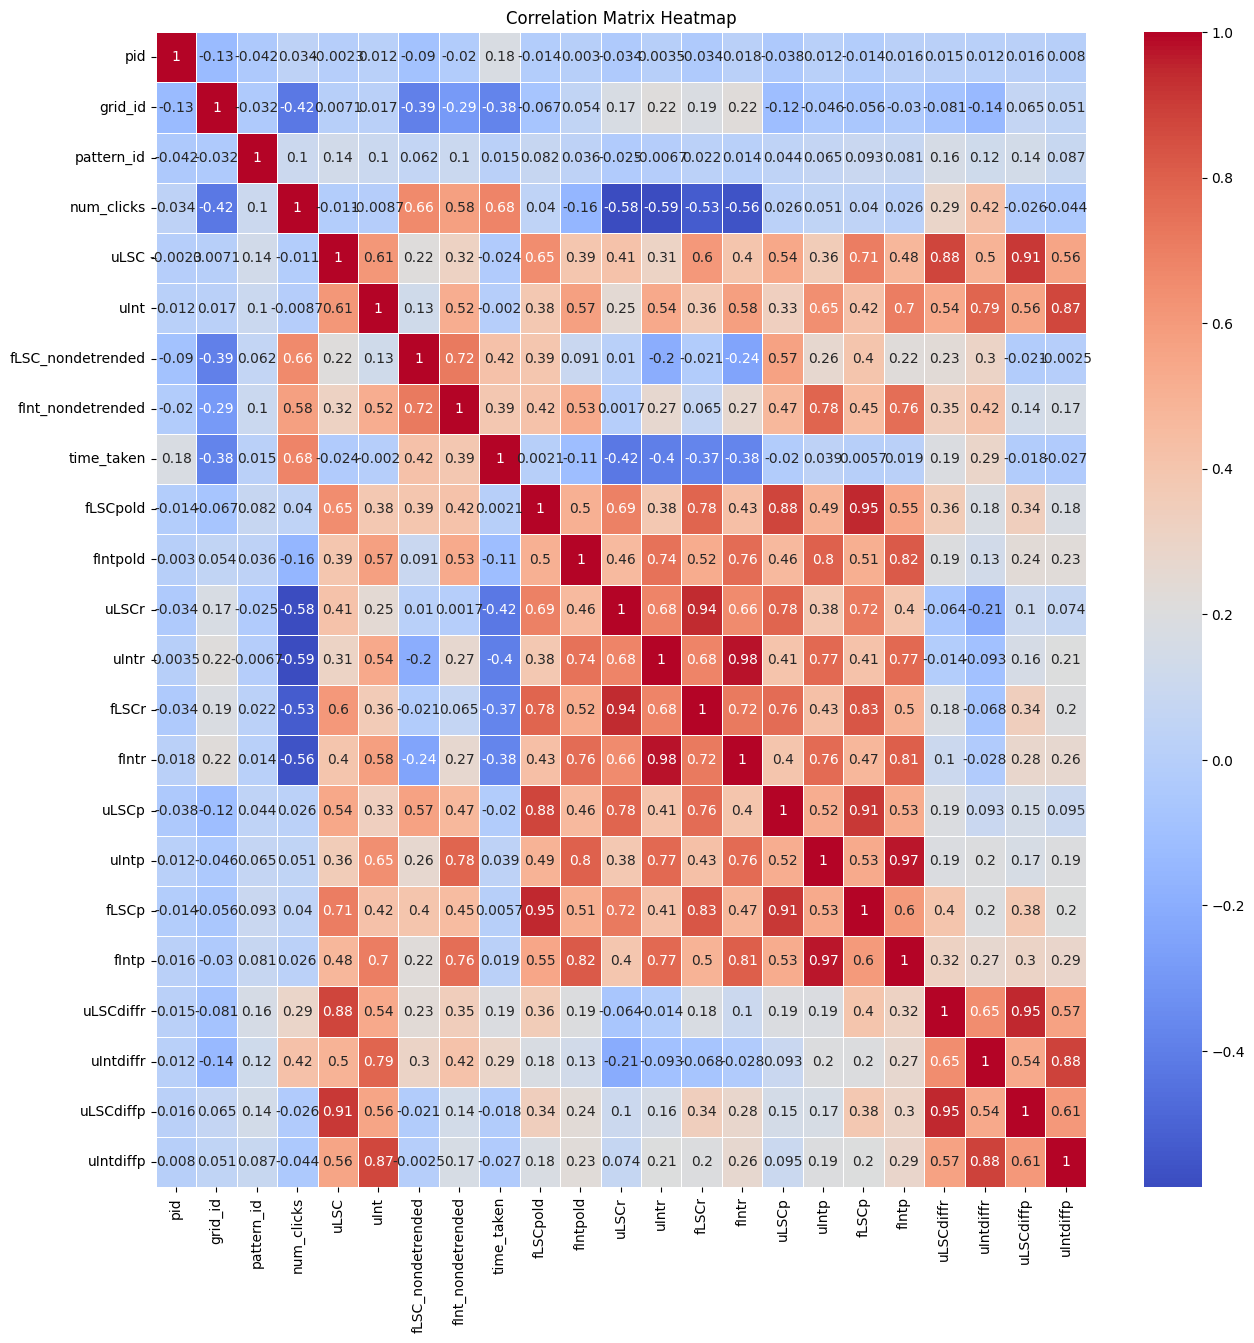

In [59]:
corr = grid_data.select_dtypes(include=[np.number]).corr()
plt.figure(figsize=(15, 15))
sns.heatmap(corr, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix Heatmap')
plt.show()

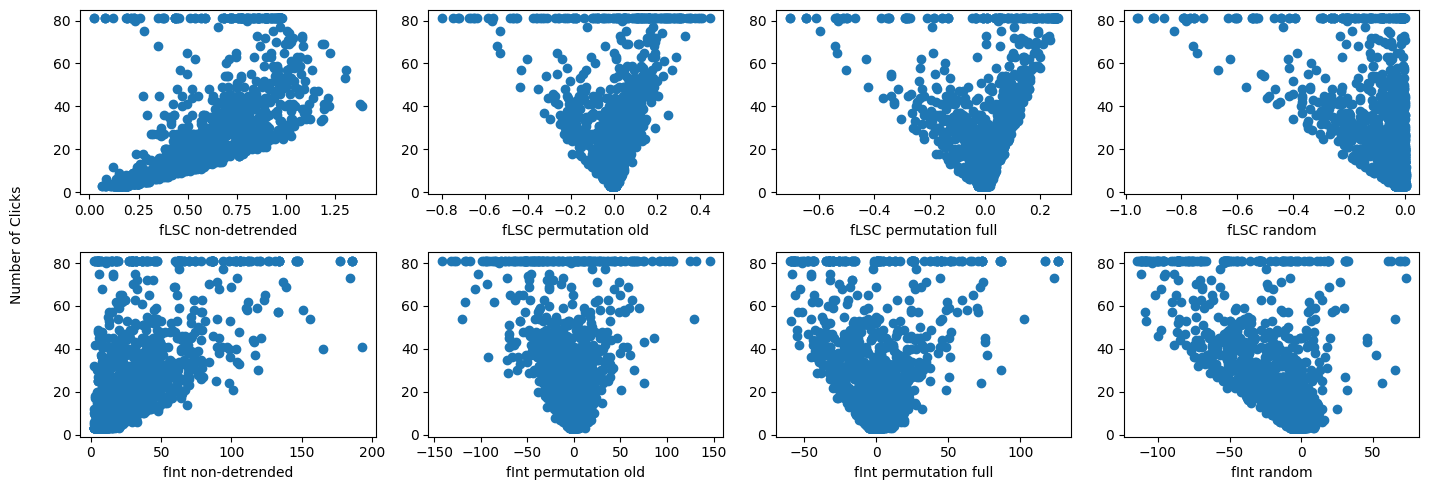

In [55]:
fig, ax = plt.subplots(2, 4, figsize=(14, 5))
ax[0, 0].scatter(grid_data["fLSC_nondetrended"], grid_data["num_clicks"])
ax[0, 0].set_xlabel("fLSC non-detrended")
ax[1, 0].scatter(grid_data["fInt_nondetrended"], grid_data["num_clicks"])
ax[1, 0].set_xlabel("fInt non-detrended")

ax[0, 1].scatter(grid_data["fLSCp1"], grid_data["num_clicks"])
ax[0, 1].set_xlabel("fLSC permutation old")
ax[1, 1].scatter(grid_data["fIntp1"], grid_data["num_clicks"])
ax[1, 1].set_xlabel("fInt permutation old")

ax[0, 2].scatter(grid_data["fLSCp2"], grid_data["num_clicks"])
ax[0, 2].set_xlabel("fLSC permutation full")
ax[1, 2].scatter(grid_data["fIntp2"], grid_data["num_clicks"])
ax[1, 2].set_xlabel("fInt permutation full")

ax[0, 3].scatter(grid_data["fLSCr"], grid_data["num_clicks"])
ax[0, 3].set_xlabel("fLSC random")
ax[1, 3].scatter(grid_data["fIntr"], grid_data["num_clicks"])
ax[1, 3].set_xlabel("fInt random")

fig.text(-0.02, 0.5, 'Number of Clicks', va='center', rotation='vertical')  # Y label centered on the left
plt.tight_layout()

In [ ]:
# click_data[["uLSC_randomised", "uInt_randomised"]] = click_data.apply(
#     lambda row: pd.Series(
#         simulate_underlying(
#             np.array(list(map(int, row["current_grid"]))).reshape(
#                 grid_size, grid_size
#             )
#         )
#     ),
#     axis=1,
# )

# click_data[["cLSC", "cInt"]] = click_data.apply(
#     lambda row: pd.Series(
#         simulate_visible(
#             np.array(list(map(int, row["current_grid"]))).reshape(
#                 grid_size, grid_size
#             ),
#             row["cLSC_nondetrended"],
#             row["cInt_nondetrended"],
#         )
#     ),
#     axis=1,
# )